# Calculate Effect Size for HFO Analysis

Using pre-calculated HFOs, determine the effect size of the difference of hfo rates pre and post resection

In [1]:
from pathlib import Path
from mne_bids import (read_raw_bids, BIDSPath,
                     get_entity_vals, get_datatypes,
                     make_report)
from mne_hfo import LineLengthDetector, RMSDetector
from mne_hfo.io import read_annotations
from mne_hfo.posthoc import compute_chs_hfo_rates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pingouin as pg
from sklearn.utils import resample
import seaborn as sns

C:\Users\patri\.virtualenvs\sickkids--kKd4nio\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Find all the paths to the result files for HFO detections. Put them into a dictionary with subjectID keys

In [2]:
reference = "average"
detector="rms"

fpaths = {
    "E1": [],
    "E3": [],
    "E4": [],
    "E5": [],
    "E6": [],
    "E7": [],
    "E8": []
}
sessions = {
    "postresection": "post",
    "preresection": "pre"
}
bids_root = Path("C:/Users/patri/Johns Hopkins/Adam Li - sickkids")
subjects = get_entity_vals(bids_root, 'subject')
derivative_path = bids_root / "derivatives"
derivative_chain = "hfo/average"
derivative_dir = derivative_path / derivative_chain
for subjectID in subjects:
    for sessionID, taskID in sessions.items():
        bids_paths = BIDSPath(subject=subjectID, session=sessionID,
                          datatype="ieeg",
                          suffix="ieeg", task=taskID,
                          acquisition='ecog',
                          processing=detector,
                          run='01',
                          extension=".vhdr", root=derivative_dir)
        hfo_fpath = str(bids_paths).replace("_ieeg.vhdr", "_desc-hfo_ieeg.tsv")
        if Path(hfo_fpath).exists():
            fpaths[subjectID].append(hfo_fpath)


Load the results into annotation dataframes. Calculate the rate of HFOs per channel and put these lists into a dictionary that separates pre and post resection detections

In [3]:
%%capture
hfos =  {
    "E1": {
        "preresection": None,
        "postresection": None,
    },
    "E3": {
        "preresection": None,
        "postresection": None,
    },
    "E4": {
        "preresection": None,
        "postresection": None,
    },
    "E5": {
        "preresection": None,
        "postresection": None,
    },
    "E6": {
        "preresection": None,
        "postresection": None,
    },
    "E7": {
        "preresection": None,
        "postresection": None,
    },
}
for subject, recordings in fpaths.items():
    if recordings:
        post_tsv = recordings[0]
        pre_tsv = recordings[1]
        # Read tsv files into annotation dataframes
        post_annotations = read_annotations(post_tsv)
        pre_annotations = read_annotations(pre_tsv)
        # Calculate hfos/min for each channel
        hfos[subject]["postresection"] = compute_chs_hfo_rates(post_annotations, 'm')
        hfos[subject]["preresection"] = compute_chs_hfo_rates(pre_annotations, 'm')

Calculate the effect size between the pre and post resection hfo detection rates. Bootstrap resample (with replacement) 50 times

In [4]:
n_resamples = 50
# Create a dictionary of subjects and effect sizes
data_dict = {
    'subject': [],
    'es': []
}
for ind, (subject, sessions) in enumerate(hfos.items()):
    # Bootstrap resample
    effects = np.zeros((n_resamples,))
    pre_rates = list(sessions["preresection"].values())
    post_rates = list(sessions["postresection"].values())
    for i in range(50):
        pre = resample(pre_rates, replace=True, n_samples=len(pre_rates))
        post = resample(post_rates, replace=True, n_samples=len(post_rates))
        effects[i] = pg.compute_effsize(pre, post, eftype='cohen')
    # Add to the dictionary with subject repeated 
    data_dict['es'].extend(effects)
    data_dict['subject'].extend([subject]*n_resamples)
# Convert dictionary to DataFrame
cohens_int = pd.DataFrame(data_dict)

Plot the results

C:\Users\patri\.virtualenvs\sickkids--kKd4nio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\patri\.virtualenvs\sickkids--kKd4nio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\patri\.virtualenvs\sickkids--kKd4nio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\patri\.virtualenvs\sickkids--kKd4nio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 58.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\patri\.virt

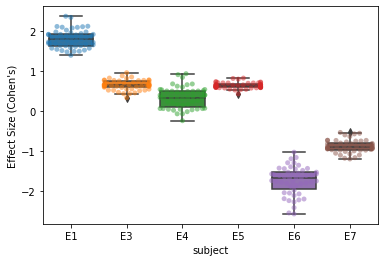

In [5]:
# Plot boxplots with overlayed scatterplot
fig, ax = plt.subplots()
sns.swarmplot(x='subject', y='es', data=cohens_int, ax=ax, alpha=0.5)
sns.boxplot(x='subject', y='es', data=cohens_int, ax=ax)
plt.ylabel('Effect Size (Cohen\'s)')
plt.savefig('hfo_effect_size.pdf')